Week 1 Challenge 

In [1]:
#import important modules

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Some configurations as defined in the challenge

In [2]:
N = 1024 # length of IDFT
CP = 32  # length of the cyclic prefix

Impulse Response

(0.0, 1024.0)

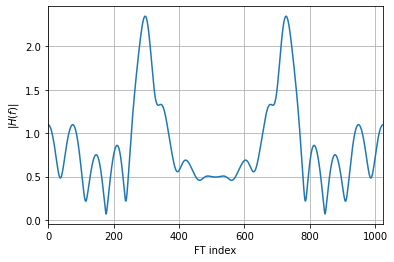

In [211]:
channelResponse = np.array(pd.read_csv("channel.csv", header = None)).ravel() # the impulse response of the wireless channel
H = np.fft.fft(channelResponse, N)

plt.plot(np.arange(N), abs(H))
plt.xlabel('FT index'); plt.ylabel('$|H(f)|$'); plt.grid(True); plt.xlim(0, N)


Set the QPSK constellation

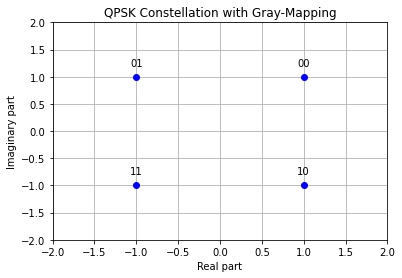

In [5]:
mu = 2 # bits per symbol 
payloadBits_per_OFDM = N*mu  # number of bits per OFDM symbol

mapping_table = {
    (0,0) : 1+1j,
    (0,1) : -1+1j,
    (1,0) : 1-1j,
    (1,1) : -1-1j
}

for b1 in [0, 1]:
    for b0 in [0, 1]:
        B = (b1, b0)
        Q = mapping_table[B]
        plt.plot(Q.real, Q.imag, 'bo')
        plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.grid(True)
plt.xlim((-2, 2)); plt.ylim((-2,2)); plt.xlabel('Real part'); plt.ylabel('Imaginary part')
plt.title('QPSK Constellation with Gray-Mapping');

In [8]:
demapping_table = {v : k for k, v in mapping_table.items()}
#demapping_table

Import data and Impulse Response

(0.0, 291456.0)

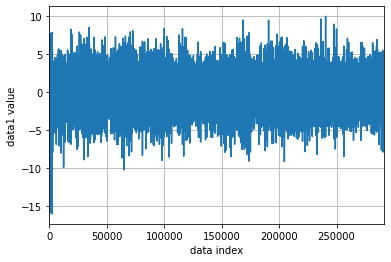

In [361]:
data1 = np.array(pd.read_csv("file6.csv", header = None)).ravel()
plt.plot(np.arange(len(data1)), data1)
plt.xlabel('data index'); plt.ylabel('data1 value'); plt.grid(True); plt.xlim(0, len(data1))

In [1]:
def removeCP(signal, a):
    return signal[a:(a+N)]

In [2]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX, N)

In [364]:
def equalize(data_demod, channel_h):
    return data_demod / (20*channel_h)

In [393]:
array2 = []
for i in range(len(data1)//1056):
    data = data1[i*1056: 1056*(i+1)]
    data = removeCP(data, CP)
    data = DFT(data)
    data = equalize(data, H)
    array2.append(data[1:512]) #first value and 512th value are 0, 513-1023 are conjugate of 1-511 so do not hold any information
    
array = np.array(array2).ravel()
len(array)

141036

Demap   


In [385]:
def Demapping(QPSK):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QPSK.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

outputdata1, hardDecision = Demapping(array)
#for qpsk, hard in zip(equalized_data1, hardDecision):
 #   plt.plot([qpsk.real, hard.real], [qpsk.imag, hard.imag], 'b-o');
 #   plt.plot(hardDecision.real, hardDecision.imag, 'ro')
#plt.grid(True); plt.xlabel('Real part'); plt.ylabel('Imaginary part'); plt.title('Hard Decision demapping');

In [394]:
data1tocsv = outputdata1.ravel()
df = pd.DataFrame(data1tocsv)
df.to_csv('data1output.csv', index=False)

str1 = ''.join(str(e) for e in data1tocsv)

In [395]:
import binascii

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return int2bytes(n).decode(encoding, errors)

def int2bytes(i):
    hex_string = '%x' % i
    n = len(hex_string)
    return binascii.unhexlify(hex_string.zfill(n + (n & 1)))

In [396]:
text_from_bits(str1[0:216])


'files/6884643201.wav\x0035202\x00'

In [359]:
def bitstring_to_bytes(s):
    return int(s, 2).to_bytes((len(s) + 7) // 8, byteorder='big')

In [399]:
array1 = bitstring_to_bytes(str1[216:])

In [401]:
# Open file in binary write mode
binary_file = open("my_file2.wav", "wb")
  
# Write bytes to file
binary_file.write(array1)
  
# Close file
binary_file.close()